## Automatic Metaphor Detection

Given a fragment of text that has a metaphor keyword in it, predict whether that fragment is actually metaphorical. Save the models for use in the `extract_metaphors` notebook.

In [ ]:
import os.path as op

import numpy as np
import seaborn as sns
import matplotlib.pyplot as plt

%config InlineBackend.figure_format = 'retina'

import pandas as pd

from tqdm import tqdm_notebook as tqdm

from allennlp.commands.elmo import ElmoEmbedder

from nltk.tokenize import RegexpTokenizer

In [2]:
DATA_PROCESSED = '../data/processed'

In [3]:
instances = pd.read_csv(op.join(DATA_PROCESSED, 'labeled.csv')).dropna()

len(instances)

5361

Load up an ELMO embedder for contextualized word embeddings.

In [4]:
elmo = ElmoEmbedder()
tokenizer = RegexpTokenizer(r'\w+')

In [5]:
def pad(s, kw_start, lim=20):
    '''
    Limit a fragment to `lim` tokens. If less than, pad with empty strings.
    '''
    
    prior = tokenizer.tokenize(s[:kw_start])
    post = tokenizer.tokenize(s[kw_start:])
    
    if len(prior) < lim/2:
        while len(prior) < lim/2:
            prior.insert(0, '')
    else:
        prior = prior[len(prior) - round(lim/2):]
        
    if len(post) < lim/2:
        while len(post) < lim/2:
            post.append('')
    else:
        post = post[:round(lim/2)]
        
    prior.extend(post)
    return prior

We create two models, one for journey metaphors and one for battle metaphors.

In [6]:
battle_fragments = [pad(fragment.fragment, int(fragment.kw_start)) for fragment in instances.loc[instances['type'] == 'battle', ['fragment', 'kw_start']].itertuples()]

journey_fragments = [pad(fragment.fragment, int(fragment.kw_start)) for fragment in instances.loc[instances['type'] == 'journey', ['fragment', 'kw_start']].itertuples()]

Embed the fragment sequences with ELMO.

In [7]:
battle_embds = elmo.embed_sentences(battle_fragments)
battle_embedded_fragments = np.array([embd[2] for embd in tqdm(battle_embds)])
journey_embds = elmo.embed_sentences(journey_fragments)
journey_embedded_fragments = np.array([embd[2] for embd in tqdm(journey_embds)])

In [8]:
battle_embedded_fragments.shape, journey_embedded_fragments.shape

((4118, 20, 1024), (807, 20, 1024))

Separate the target values: whether a fragment is truly metaphorical

In [9]:
y_data_battle = instances.loc[instances['type'] == 'battle', 'metaphorical'].astype(int).values
y_data_journey = instances.loc[instances['type'] == 'journey', 'metaphorical'].astype(int).values

In [10]:
from sklearn.model_selection import StratifiedKFold, train_test_split

In [11]:
X_train_battle, X_test_battle, y_train_battle, y_test_battle = train_test_split(battle_embedded_fragments, y_data_battle, train_size=0.8, stratify=y_data_battle)
X_train_journey, X_test_journey, y_train_journey, y_test_journey = train_test_split(journey_embedded_fragments, y_data_journey, train_size=0.8, stratify=y_data_journey)

/Users/alex/anaconda3/envs/nlp/lib/python3.6/site-packages/sklearn/model_selection/_split.py:2179: FutureWarning: From version 0.21, test_size will always complement train_size unless both are specified.
  FutureWarning)
/Users/alex/anaconda3/envs/nlp/lib/python3.6/site-packages/sklearn/model_selection/_split.py:2179: FutureWarning: From version 0.21, test_size will always complement train_size unless both are specified.
  FutureWarning)


# Building Models

In [12]:
from keras import backend as K
from keras.layers import *
from keras.models import Model
from keras import optimizers
from keras.callbacks import EarlyStopping

from sklearn import metrics

from datetime import datetime

from skopt.space import Real, Categorical, Integer
from skopt.utils import use_named_args
from skopt import gp_minimize

Using TensorFlow backend.


Based on *Detecting Figurative Word Occurrences Using Recurrent Neural Networks* (Mykowiecka et al. 2018)

https://github.com/gao-g/metaphor-in-context/blob/master/classification/main_vua.py

In [13]:
def build_model(dropout, hidden_layers, hidden_units, lr):
    inputs = Input(shape=(20, 1024), name="input")
    
    x = Bidirectional(GRU(20, return_sequences=True, name="gru"))(inputs)
    x = Dropout(dropout)(x)
    x = Bidirectional(GRU(20, name='gru2'))(x)

    for lyr in range(1,hidden_layers+1):
        x = Dropout(dropout)(x)
        x = Dense(int(round(hidden_units/lyr)), activation='relu', name=f"dense{lyr+1}")(x)
        
    predictions = Dense(1, activation='sigmoid', name="out")(x)
    _model = Model(inputs=inputs, outputs=predictions)

    _model.compile(optimizer=optimizers.Adam(lr=lr, decay=0.1),
                  loss='binary_crossentropy')
    
    return _model

Perform some parameter search and cross validation. This can take a while.

In [14]:
space = [Real(0.05, 0.5, 'uniform', name='dropout'),
         Integer(1, 2, name='hidden_layers'),
         Integer(6, 20, name='hidden_units'),
         Real(1e-3, 0.1, 'log-uniform', name='lr'),
         Real(2, 60, 'uniform', name='class_weight'),
         Integer(5,15, name='epochs')]

### Battle Model Hyperparameter Optimization

In [16]:
kfold = StratifiedKFold(n_splits=6, shuffle=True)

@use_named_args(space)
def objective(**params):
    
    kappas = []
            
    model_obj = build_model(params['dropout'], params['hidden_layers'], 
                              params['hidden_units'], params['lr'])
    
    for fold, (train_ixs, val_ixs) in enumerate(kfold.split(X_train_battle, y_train_battle)):

        weights = {0: params['class_weight'], 1: 1.0}

        model_obj.fit(X_train_battle[train_ixs], y_train_battle[train_ixs], 
                  epochs=params['epochs'],
                  validation_data=(X_train_battle[val_ixs], y_train_battle[val_ixs]), 
                  class_weight=weights, 
                  verbose=0)

        preds = (model_obj.predict(X_train_battle[val_ixs]) > 0.5).astype(int)

        model_obj.reset_states()

        kappa = metrics.cohen_kappa_score(y_train_battle[val_ixs], preds)

        kappas.append(kappa)
        
        del preds

        if fold == 3:
            # break after completing 4/6 of the folds. This just saves time.
            break
            
    print()
    print(f'\t E: {params["epochs"]} D: {params["dropout"]:.3f} L: {params["hidden_layers"]} U: {params["hidden_units"]} LR: {params["lr"]:.3f} W: {params["class_weight"]:.2f}')
          
    return 1-np.mean(kappas)

In [17]:
print(datetime.now())

res_gp = gp_minimize(objective, space, n_calls=50, n_random_starts=10, acq_func="EI", 
                     acq_optimizer="auto", verbose=True, n_jobs=3)

print(f'Best Kappa: {1-res_gp.fun:.3f} at {res_gp.x}')

2019-03-17 09:42:04.946688
Iteration No: 1 started. Evaluating function at random point.

	 E: 10 D: 0.187 L: 2 U: 18 LR: 0.003 W: 53.84
Iteration No: 1 ended. Evaluation done at random point.
Time taken: 243.8018
Function value obtained: 0.5668
Current minimum: 0.5668
Iteration No: 2 started. Evaluating function at random point.

	 E: 12 D: 0.116 L: 3 U: 14 LR: 0.001 W: 15.24
Iteration No: 2 ended. Evaluation done at random point.
Time taken: 276.9906
Function value obtained: 0.9116
Current minimum: 0.5668
Iteration No: 3 started. Evaluating function at random point.

	 E: 15 D: 0.013 L: 2 U: 16 LR: 0.002 W: 39.25
Iteration No: 3 ended. Evaluation done at random point.
Time taken: 329.6234
Function value obtained: 0.6184
Current minimum: 0.5668
Iteration No: 4 started. Evaluating function at random point.

	 E: 9 D: 0.362 L: 1 U: 15 LR: 0.007 W: 16.74
Iteration No: 4 ended. Evaluation done at random point.
Time taken: 205.6008
Function value obtained: 0.2762
Current minimum: 0.2762
It


	 E: 5 D: 0.000 L: 1 U: 8 LR: 0.007 W: 60.00
Iteration No: 34 ended. Search finished for the next optimal point.
Time taken: 168.9750
Function value obtained: 0.1644
Current minimum: 0.1129
Iteration No: 35 started. Searching for the next optimal point.

	 E: 15 D: 0.343 L: 1 U: 8 LR: 0.014 W: 18.92
Iteration No: 35 ended. Search finished for the next optimal point.
Time taken: 440.8550
Function value obtained: 0.1467
Current minimum: 0.1129
Iteration No: 36 started. Searching for the next optimal point.

	 E: 5 D: 0.363 L: 1 U: 8 LR: 0.010 W: 2.00
Iteration No: 36 ended. Search finished for the next optimal point.
Time taken: 169.0955
Function value obtained: 0.1788
Current minimum: 0.1129
Iteration No: 37 started. Searching for the next optimal point.

	 E: 5 D: 0.303 L: 1 U: 20 LR: 0.017 W: 26.96
Iteration No: 37 ended. Search finished for the next optimal point.
Time taken: 166.8246
Function value obtained: 0.2216
Current minimum: 0.1129
Iteration No: 38 started. Searching for the

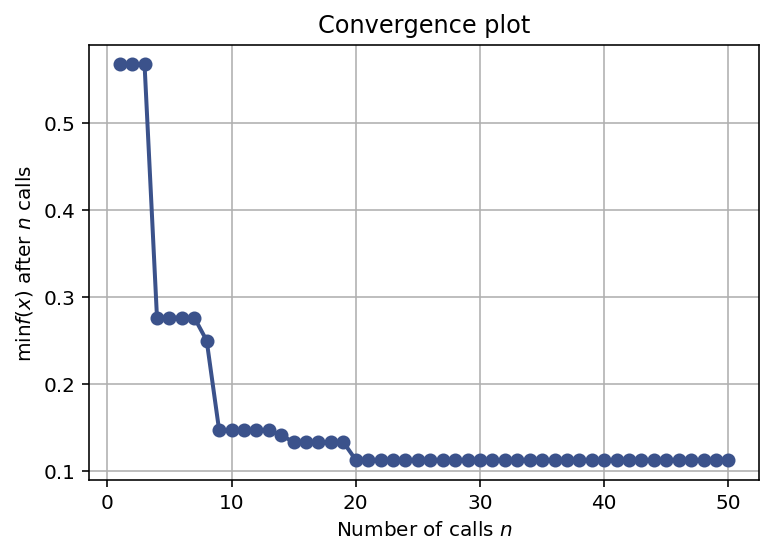

In [18]:
from skopt.plots import plot_convergence

plot_convergence(res_gp);

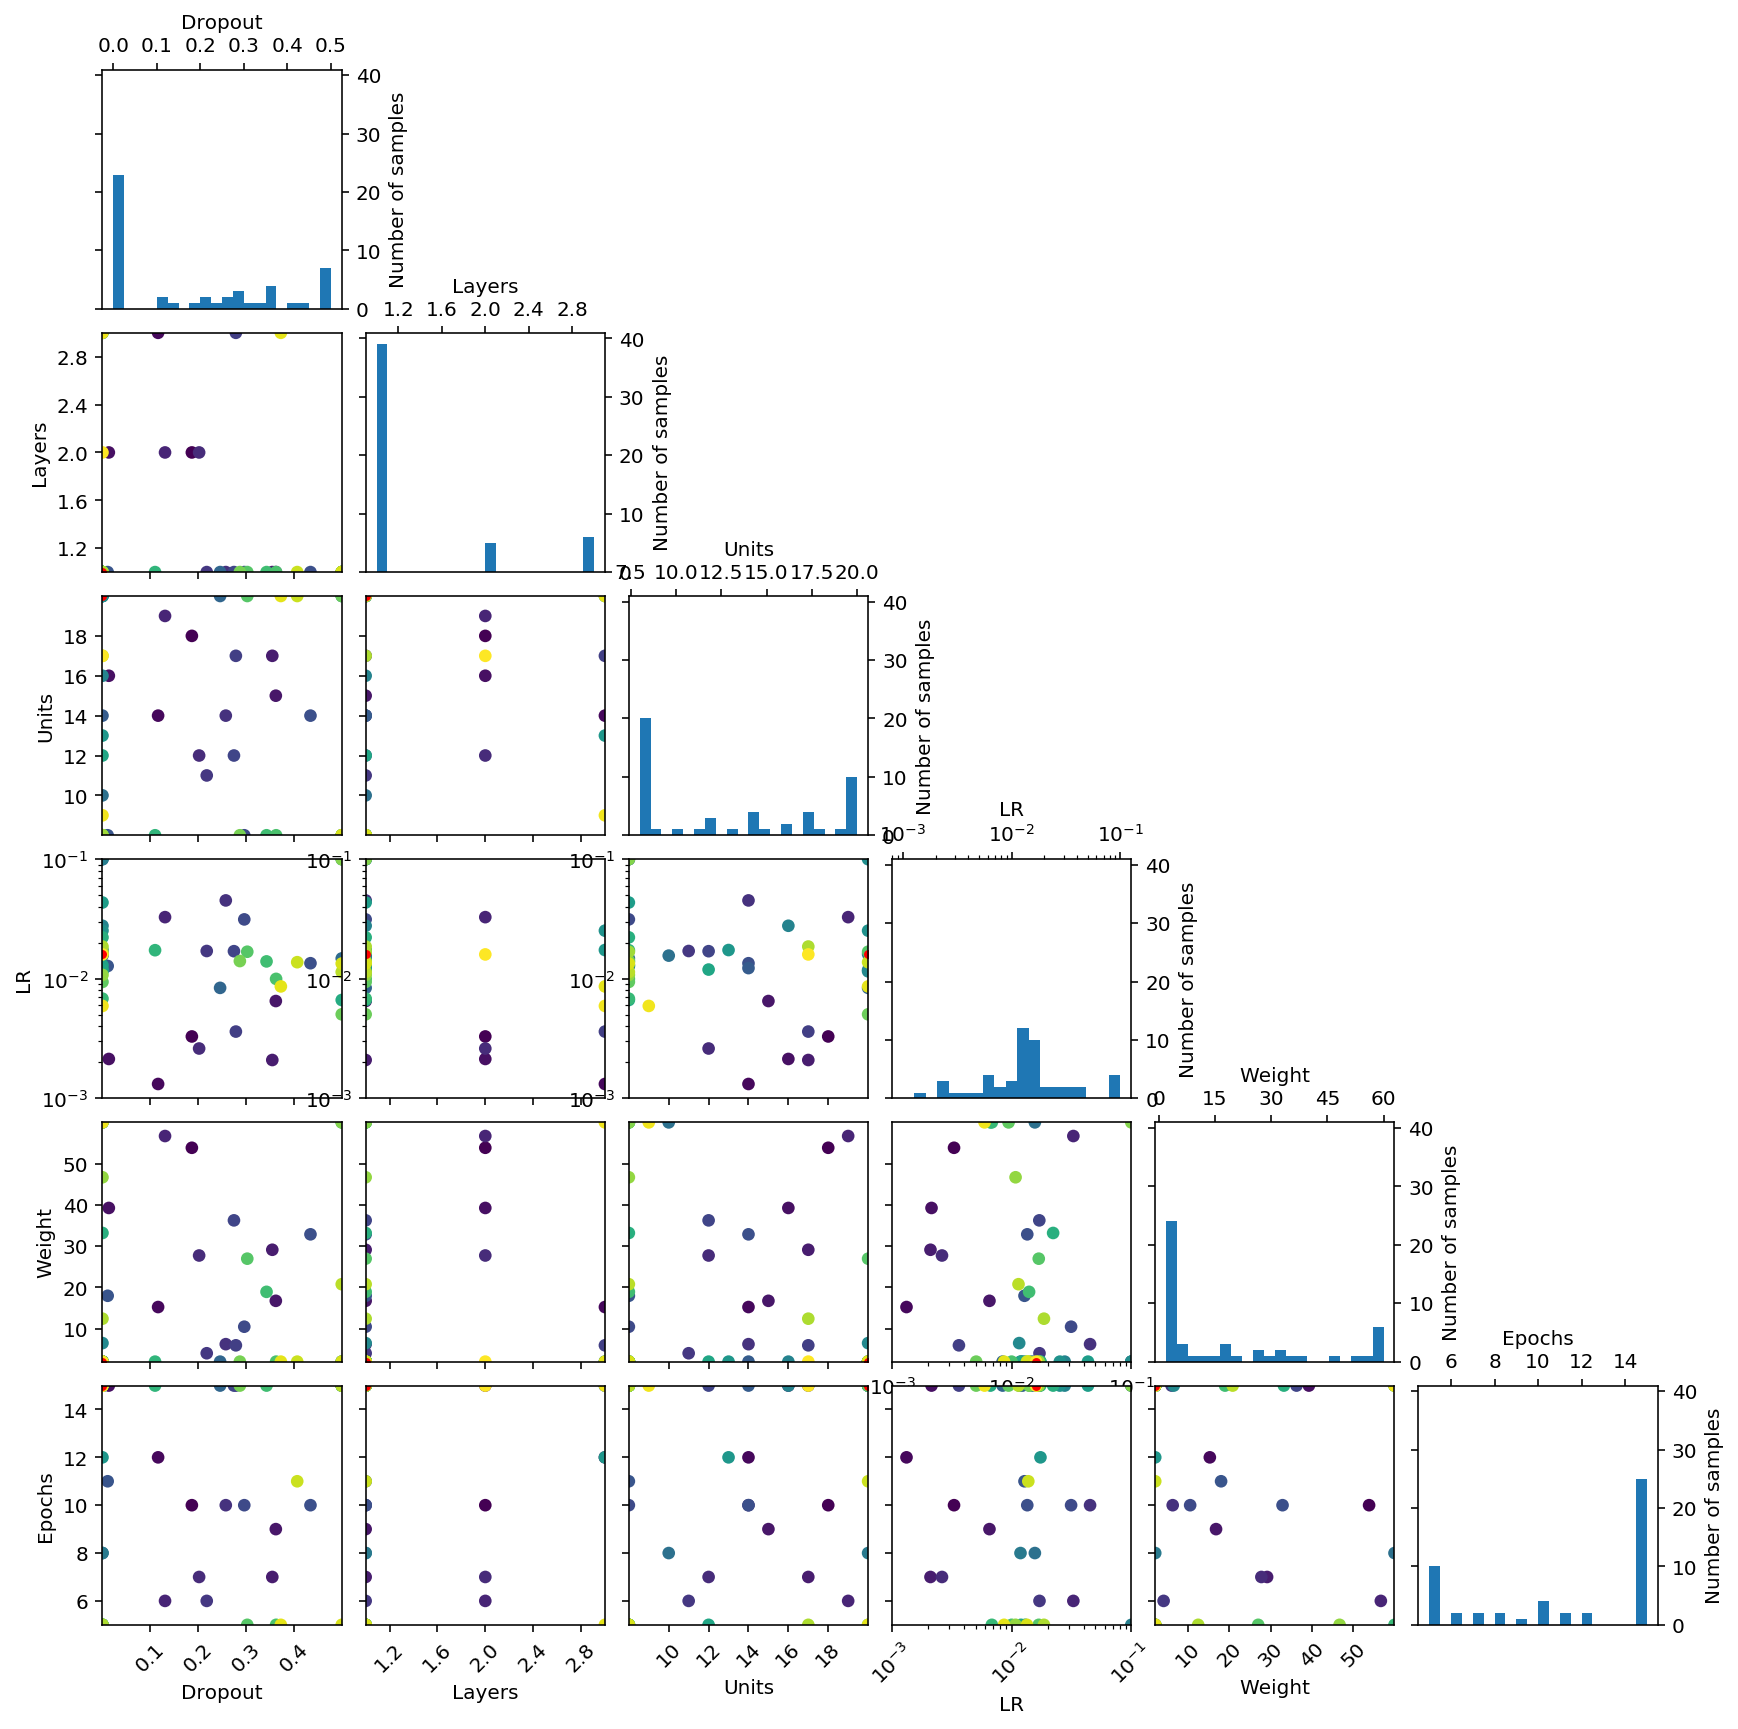

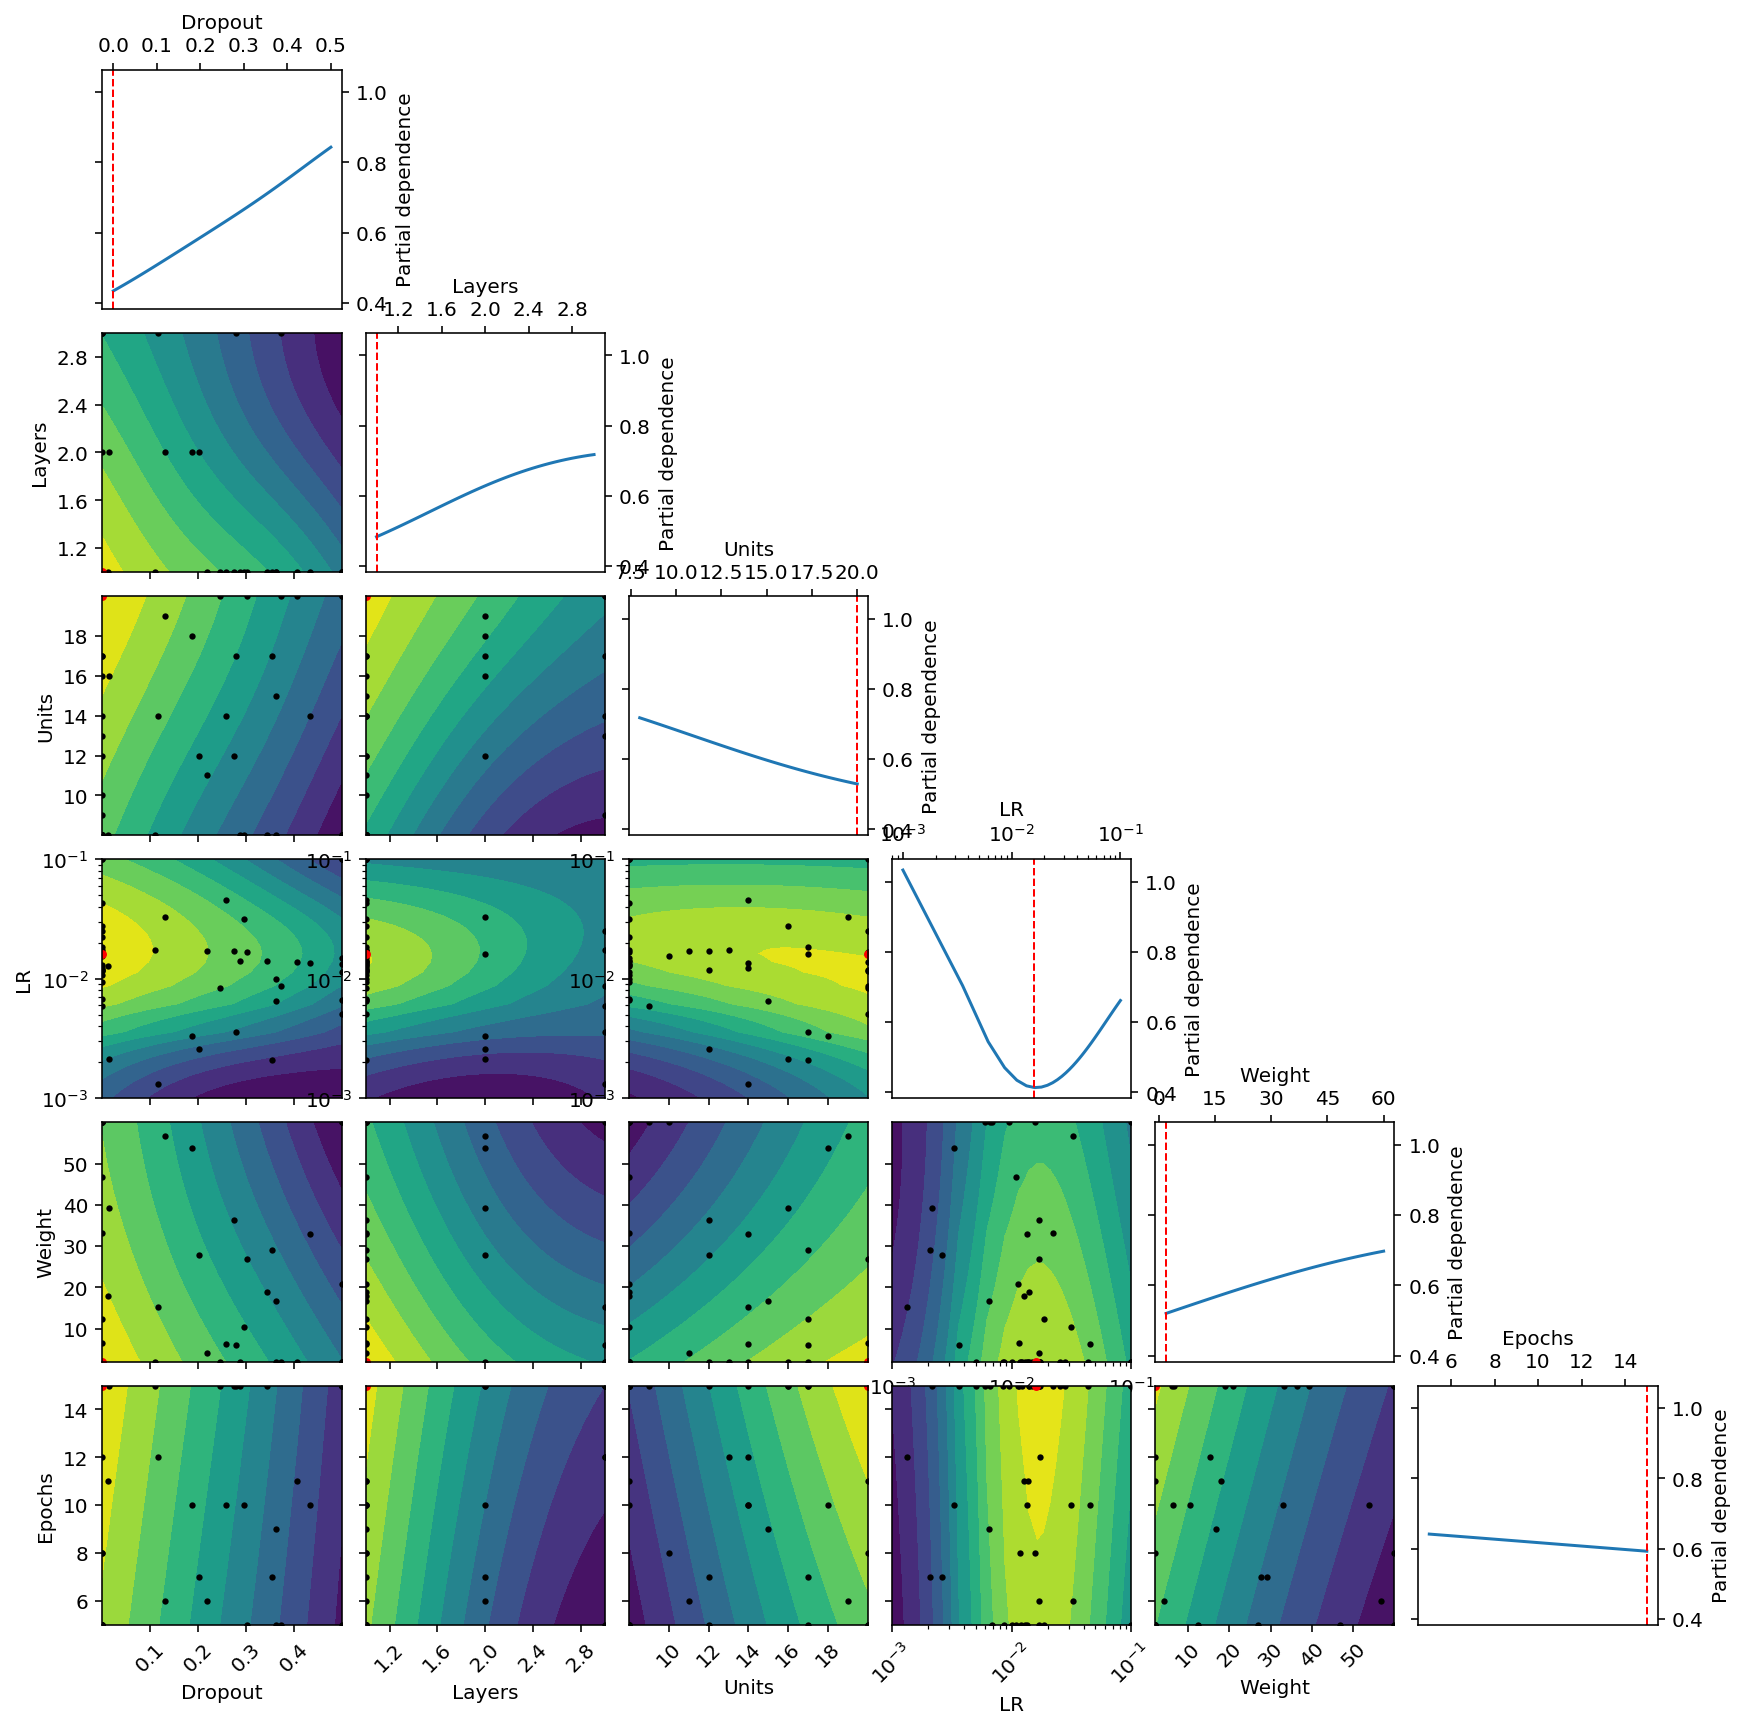

In [22]:
from skopt.plots import plot_evaluations, plot_objective

plot_evaluations(res_gp, dimensions=['Dropout', 'Layers', 'Units', 'LR', 'Weight', 'Epochs']);
plot_objective(res_gp, dimensions=['Dropout', 'Layers', 'Units', 'LR', 'Weight', 'Epochs']);

### Journey Model Hyperparameter Optimization

In [74]:
kfold = StratifiedKFold(n_splits=5, shuffle=True)

earlystop = EarlyStopping(monitor='val_loss', patience=3)

@use_named_args(space)
def objective(**params):
    
    kappas = []
            
    model_obj = build_model(params['model'], params['dropout'], params['hidden_layers'], 
                              params['hidden_units'], params['lr'])

    for fold, (train_ixs, val_ixs) in enumerate(kfold.split(X_train_journey, y_train_journey)):
        now = datetime.now()

        weights = {0: params['class_weight'], 1: 1.0}

        history = model_obj.fit(X_train_journey[train_ixs], y_train_journey[train_ixs], epochs=30,
                  validation_data=(X_train_journey[val_ixs], y_train_journey[val_ixs]), 
                  class_weight=weights, callbacks=[earlystop], 
                  verbose=0)

        preds = (model_obj.predict(X_train_journey[val_ixs]) > 0.5).astype(int)

        model_obj.reset_states()

        kappa = metrics.cohen_kappa_score(y_train_journey[val_ixs], preds)

        kappas.append(kappa)

        del history, preds

        if fold == 2:
            break
            
    print(f'\t {params["model"]} {params["dropout"]:.3f} {params["hidden_layers"]} {params["hidden_units"]} {params["lr"]:.3f} {params["class_weight"]:.2f}')
    
    return 1-np.mean(kappas)

In [75]:
res_gp_j = gp_minimize(objective, space, n_calls=16, n_random_starts=8, acq_func="PI", 
                     x0=['gru', 0.0, 1, 8, 0.026881, 16.3068],
                     acq_optimizer="auto", verbose=True, n_jobs=3)

print(f'Best: {res_gp_j.fun} at {res_gp_j.x}')

Iteration No: 1 started. Evaluating function at provided point.
	 gru 0.000 1 8 0.027 16.31
Iteration No: 1 ended. Evaluation done at provided point.
Time taken: 86.8615
Function value obtained: 0.3009
Current minimum: 0.3009
Iteration No: 2 started. Evaluating function at random point.
	 lstm 0.403 2 8 0.009 19.03
Iteration No: 2 ended. Evaluation done at random point.
Time taken: 61.4794
Function value obtained: 1.0000
Current minimum: 0.3009
Iteration No: 3 started. Evaluating function at random point.
	 gru 0.362 2 17 0.003 16.73
Iteration No: 3 ended. Evaluation done at random point.
Time taken: 67.7568
Function value obtained: 1.0000
Current minimum: 0.3009
Iteration No: 4 started. Evaluating function at random point.
	 gru 0.152 2 17 0.015 18.60
Iteration No: 4 ended. Evaluation done at random point.
Time taken: 60.9893
Function value obtained: 0.4730
Current minimum: 0.3009
Iteration No: 5 started. Evaluating function at random point.
	 lstm 0.380 2 18 0.002 17.46
Iteration No:

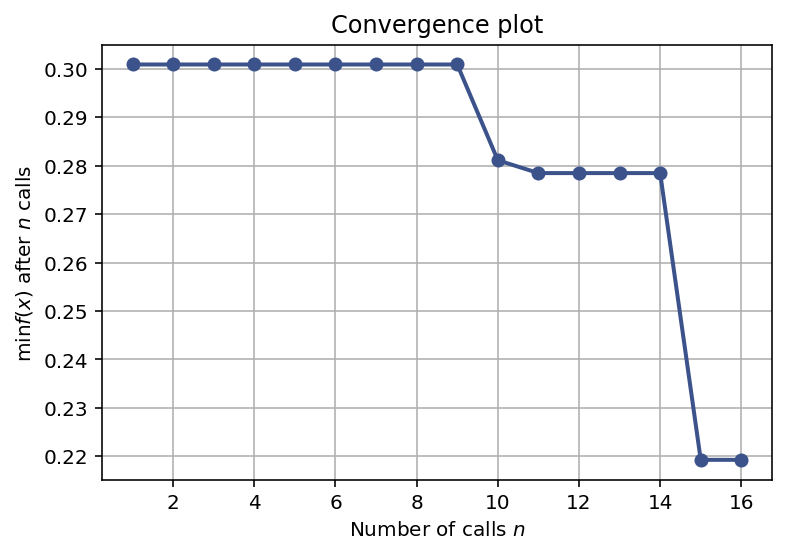

In [76]:
plot_convergence(res_gp_j);

## Model Building

In [23]:
battle_model = build_model('gru', 0, 1, 20, 0.016075)
battle_model.reset_states()
weights = {0: 2.0, 1: 1.0}

battle_model.fit(X_train_battle, y_train_battle, 
        epochs=15, class_weight=weights,
        verbose=1)

battle_preds = (battle_model.predict(X_test_battle) > 0.5).astype(int)

Epoch 1/15
3294/3294 [==============================] - 47s 14ms/step - loss: 0.3813
Epoch 2/15
3294/3294 [==============================] - 7s 2ms/step - loss: 0.1923
Epoch 3/15
3294/3294 [==============================] - 8s 2ms/step - loss: 0.1023
Epoch 4/15
3294/3294 [==============================] - 9s 3ms/step - loss: 0.0606
Epoch 5/15
3294/3294 [==============================] - 7s 2ms/step - loss: 0.0419
Epoch 6/15
3294/3294 [==============================] - 9s 3ms/step - loss: 0.0302
Epoch 7/15
3294/3294 [==============================] - 9s 3ms/step - loss: 0.0219
Epoch 8/15
3294/3294 [==============================] - 7s 2ms/step - loss: 0.0178
Epoch 9/15
3294/3294 [==============================] - 7s 2ms/step - loss: 0.0142
Epoch 10/15
3294/3294 [==============================] - 7s 2ms/step - loss: 0.0106
Epoch 11/15
3294/3294 [==============================] - 7s 2ms/step - loss: 0.0065
Epoch 12/15
3294/3294 [==============================] - 7s 2ms/step - loss: 0.0048

In [24]:
print('Battle Model Cohen\'s Kappa:')
print(f'{metrics.cohen_kappa_score(y_test_battle, battle_preds):.3f}')
# print('Journey Model Cohen\'s Kappa:')
# print(f'{metrics.cohen_kappa_score(y_test_journey, journey_preds.argmax(axis=1)):.3f}')

Battle Model Cohen's Kappa:
0.413
